In [22]:
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
import pandas as pd

from ImageRetrieval import NNet, VLAD

In [2]:
def plot_image(img):
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.imshow(img, cmap='gray');

In [3]:
def compose_panorama(root, ext):
    img_paths = [f"{root}_{i}{ext}" for i in range(3)]
    images = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in img_paths]

    return np.hstack(images)

In [4]:
def calculate_distance(pt1, pt2):
    '''
        Calculate distance between two points
        which have geodesic coordinates using haversine formula
    '''

    R = 6371000
    pt1_r = np.radians(pt1)
    pt2_r = np.radians(pt2)

    dphi = pt2_r[0] - pt1_r[0]
    dlam = pt2_r[1] - pt1_r[1]

    a = np.sin(dphi/2)**2 + np.cos(pt1_r[0]) * np.cos(pt2_r[0]) * np.sin(dlam / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return R * c

In [5]:
def extract_coordinates(path):
    filename = os.path.splitext(os.path.basename(path))[0]
    parts = filename.split('_')
    
    latitude = float(parts[-2])
    longitude = float(parts[-1])

    return latitude, longitude

In [6]:
def compare_images(query_img_path, db_image_path):
    # Compare two images given their paths

    query_img = cv.cvtColor(cv.imread(query_img_path), cv.COLOR_BGR2RGB)
    db_img_root, db_img_ext = os.path.splitext(db_image_path)
    db_panorama = compose_panorama(db_img_root, db_img_ext)

    latitude, longitude = extract_coordinates(db_img_root)

    fig, axes = plt.subplots(2, 1, figsize=(20, 8))
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title("Query image")
    axes[0].axis("off")
    
    axes[1].imshow(db_panorama, cmap='gray')
    axes[1].set_title("DB image. latitude={}, longtitude={}".format(latitude, longitude))
    axes[1].axis("off")

    plt.show()

In [7]:
def stratified_image_split(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    for district in os.listdir(source_dir):
        district_path = os.path.join(source_dir, district)
        if not os.path.isdir(district_path):
            continue
        
        images = sorted(os.listdir(district_path))
        triplet_ids = list(set([img.rsplit('_', 1)[0] for img in images]))
        
        train_triplets, test_triplets = train_test_split(triplet_ids, test_size=test_size, random_state=random_state)
        
        for triplet in train_triplets:
            for i in range(3):
                src = os.path.join(district_path, f"{triplet}_{i}.jpg")
                dst_district = os.path.join(train_dir, district)
                os.makedirs(dst_district, exist_ok=True)
                if os.path.exists(src):
                    print(f"Copying {src} -> {dst_district}")
                    shutil.copy(src, dst_district)
                else:
                    print(f"File not found: {src}")  

        for triplet in test_triplets:
            img_paths = [os.path.join(district_path, f"{triplet}_{i}.jpg") for i in range(3)]
            images = [cv.imread(path) for path in img_paths if os.path.exists(path)]
            
            if len(images) == 3:
                panorama = np.hstack(images)
                dst_district = os.path.join(test_dir, district)
                os.makedirs(dst_district, exist_ok=True)
                panorama_path = os.path.join(dst_district, f"{triplet}.jpg")
                cv.imwrite(panorama_path, panorama)
                print(f"Saved panorama: {panorama_path}")
            else:
                print(f"Skipping {triplet}, missing images")

In [ ]:
source_folder = "assets/Images"
train_folder = "assets/train_images"
test_folder = "assets/test_images"

stratified_image_split(source_folder, train_folder, test_folder, test_size=0.2)

In [9]:
root_path = os.path.join("assets", 'dbs')
root_path

'assets/dbs'

In [10]:
nn_db_path = os.path.join(root_path, 'db_nn')
nn_retriever = NNet(nn_db_path, create=True, verbose=True)

In [11]:
nn_retriever.fit(train_folder)

Processing subdirectories: 100%|██████████| 6/6 [01:10<00:00, 11.70s/it]


Storing vectors in database...


Saving embeddings: 100%|██████████| 1127/1127 [00:03<00:00, 321.39it/s]


In [12]:
vlad_db_path = os.path.join(root_path, 'db_vlad')
vlad_retriever = VLAD(vlad_db_path, create=True, k=1536, features_nb=3000, verbose=True)

In [13]:
vlad_retriever.fit(train_folder)

Processing subdirectories: 100%|██████████| 6/6 [02:33<00:00, 25.54s/it]


Clustering started...
Clustering ended.
Saved codebook to assets/dbs/db_vlad/codebook.npy


Extracting VLADs: 100%|██████████| 1127/1127 [18:13<00:00,  1.03it/s]


Storing vectors in database...


Saving embeddings: 100%|██████████| 1127/1127 [00:58<00:00, 19.12it/s]


### Example

In [14]:
query_image_path = "assets/QueryImages/example1.jpg"

Retrieved image path: assets/train_images/50.44954_30.46079_1000/image_50.450459_30.459622.jpg


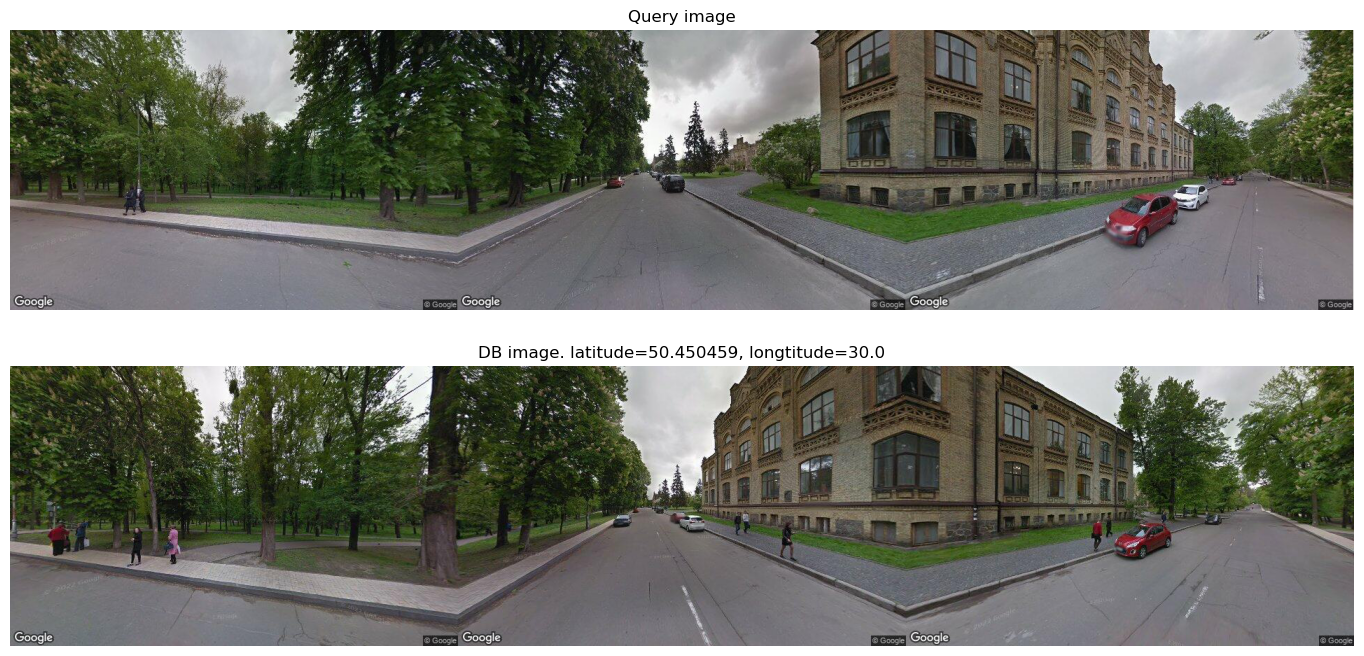

In [15]:
best_match_path = vlad_retriever.predict(query_image_path)

print("Retrieved image path:", best_match_path)
compare_images(query_image_path, best_match_path)

Retrieved image path: assets/train_images/50.44954_30.46079_1000/image_50.449965_30.462656.jpg


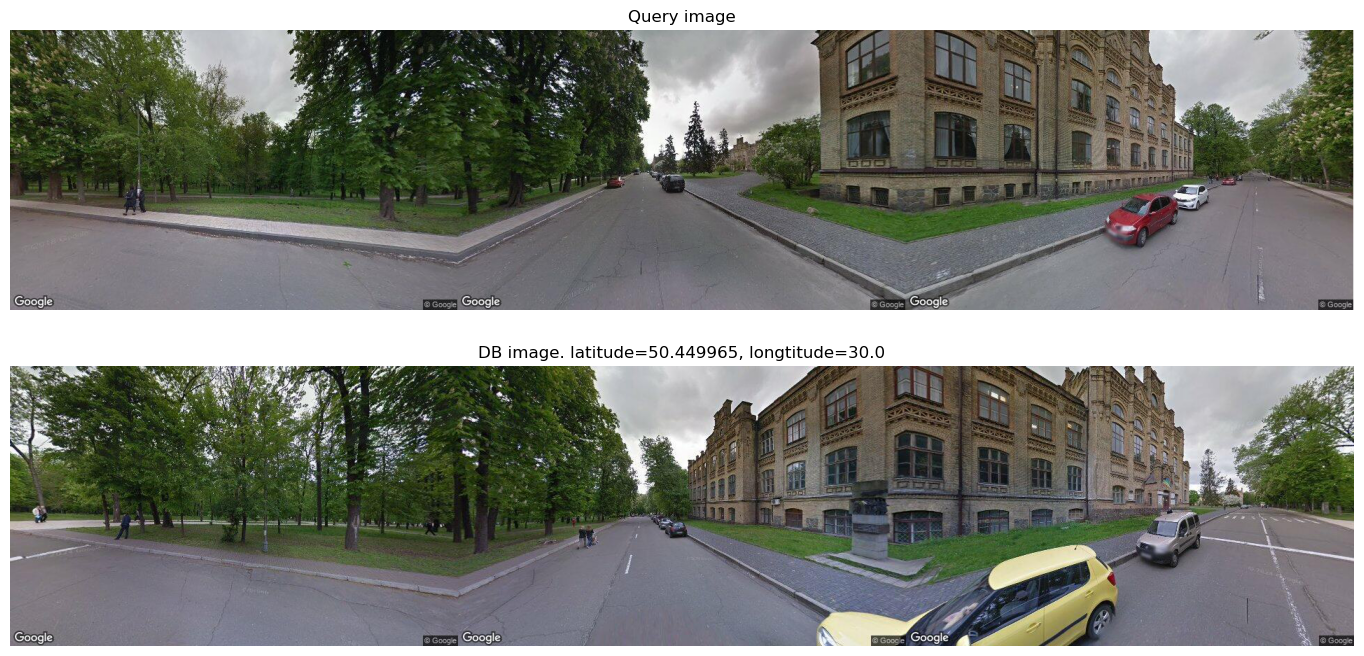

In [16]:
best_match_path = nn_retriever.predict(query_image_path)

print("Retrieved image path:", best_match_path)
compare_images(query_image_path, best_match_path)

### Comparison

In [17]:
def calculate_offset_distances(model, test_folder_path):
    distances = []

    subdirs = sorted(os.listdir(test_folder_path))

    for subdir_name in subdirs:
        subdir_path = os.path.join(test_folder_path, subdir_name)

        if not os.path.isdir(subdir_path):  
            continue

        files = sorted(os.listdir(subdir_path))

        for file in files:
            panorama_path = os.path.join(subdir_path, file)
            predicted_path = model.predict(panorama_path)
            
            test_coordinates = extract_coordinates(panorama_path)
            predicted_coordinates = extract_coordinates(predicted_path)
            
            distance = calculate_distance(test_coordinates, predicted_coordinates)
            distances.append(distance)


    return np.array(distances)

In [18]:
vlad_distances = calculate_offset_distances(vlad_retriever, test_folder)
nn_distances = calculate_offset_distances(nn_retriever, test_folder)

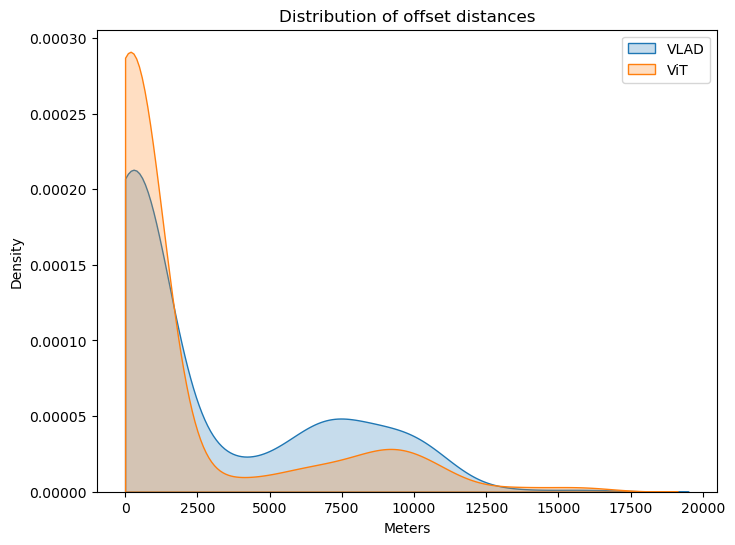

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.kdeplot(vlad_distances, clip=(0, np.inf), fill=True, ax=ax, label='VLAD')
sns.kdeplot(nn_distances, clip=(0, np.inf), fill=True, ax=ax, label='ViT')

ax.set_xlabel("Meters")
ax.set_title("Distribution of offset distances")

plt.legend()

In [26]:
df = pd.DataFrame({
    "VLAD_distance_offset": vlad_distances,
    "ViT_distance_offset": nn_distances
})

# Compute summary statistics
stats = df.describe().T 
stats = stats.drop(columns=['count'])

stats["median"] = df.median()
stats

,mean,std,min,25%,50%,75%,max,median
VLAD_distance_offset,2712.840968,3710.057164,10.666133,76.204882,439.425857,5990.406656,15912.274914,439.425857
ViT_distance_offset,1687.029488,3414.339938,9.621550,41.873662,141.864073,567.338622,15827.884523,141.864073
